# 探索贸易数据网络

In [1]:
import sys
sys.path.append("..")

# 依赖项
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

# 自己写的
from module.trade_table import TradeTable
from tools.common_used import yellow_river_provinces, export_virtue_water_matrix, ENG_NAME
from tools.mk_test import mk_test
from tools.bipartite_network_explore import plot_bipartite_graph, get_mean_nearest_nbr_degree
from tools.plot_gam import plot_gam_and_interval

# 加载处理后数据
total = pd.read_csv(r"../data/interim/total_nvwi_inner.csv")
identify = pd.read_csv("../data/external/pnas_identified.csv", index_col=0)

### 第一深度：该地区出口农产品的普及率

黄河生产的农产品相对来说非常特别（别的地方不产）

In [2]:
def get_all_index_results(data, depth):
    """
    获得所有的最近邻平均度 knn
    params: data, 一个可以转化成 TradeTable 的对象
    params: depth, 计算 KNN 的计算深度
    
    return: 各省份的计算结果
    """
    yrs = data.Year.sort_values().unique()
    result = pd.DataFrame(index=total['Province Name'].unique())
    for y in yrs:
        matrix = export_virtue_water_matrix(data, y)
        knn = TradeTable(matrix).get_knn_dict(depth=depth)
        result[y] = knn
    return result

result_depth1 = get_all_index_results(total, depth=1)

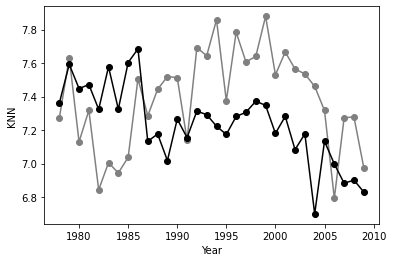

In [3]:
def plot_mean_yr_china(result, ax=False):
    if not ax:
        fig, ax = plt.subplots()
    x = result.columns
    y_yr = result.loc[yellow_river_provinces, :].mean().values
    y_all = result.mean().values
    ax.plot(x, y_all, "-o", label='Mean, {}'.format(mk_test(y_all)[0]), color='gray')
    ax.plot(result.columns, y_yr, "-o", color='black', label="Yellow River, {}".format(mk_test(y_yr)[0]))
    ax.set_xlabel('Year')
    ax.set_ylabel("KNN")
    
plot_mean_yr_china(result_depth1)
plt.show();

一层深度的 knn 逐渐显著下降，表明黄河流域的农产品独特性在增加

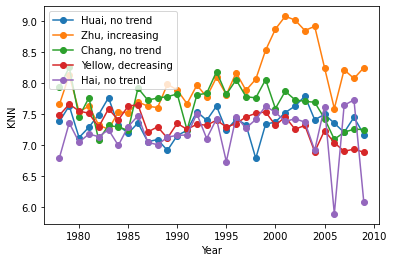

In [4]:
# 各流域相关的省

def plot_mean_basins(result, ax=False):
    """
    绘制各主要流域的变化趋势
    params: result, 各省
    """
    if not ax:
        fig, ax = plt.subplots()
    x = result.columns

    basin_province_dict = {}
    test = []
    for basin in ENG_NAME:
        provinces_included = identify[identify['MNAME_CH'] == basin]['Province_n'].unique().tolist()
        basin_province_dict[ENG_NAME[basin]] = provinces_included
        y = result.loc[provinces_included, :].mean().values
        trend = mk_test(y, 0.01)[0]
        ax.plot(x, y , "-o", label="{}, {}".format(ENG_NAME[basin], trend))    
    ax.set_xlabel('Year')
    ax.set_ylabel("KNN")
    ax.legend();
    
plot_mean_basins(result_depth1)

### 第二深度

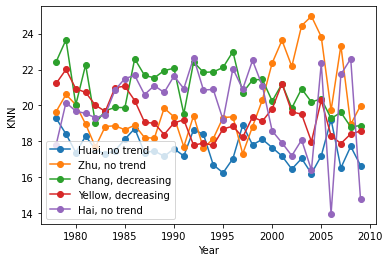

In [5]:
result_depth2 = get_all_index_results(total, depth=2)
plot_mean_basins(result_depth2)

### 第三深度

与该地区输出农产品种类类似的其他省份，在其出口产品上的平均多样性。越大代表越多样。

与黄河流域的农产品竞争的其他省份，在1985-2000年之间多样性很低的。

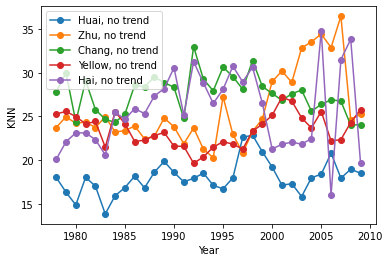

In [6]:
result_depth3 = get_all_index_results(total, depth=3)
plot_mean_basins(result_depth3)

第三深度先减小后增加

## 四种生成随机网的方法：

- NULL1: 两边儿的结点相等，保持相同的边数量，随机链接
- NULL2: 控制一边儿的度序列（多少个连边与之相关），但链接的另一边儿的目标随机，总边数量也是相同的
- NULL3: 与NULL2对称，用另一边儿
- NULL4: 边模仿，所以国家的多样性和普遍性与经验数据完全相同

In [7]:
# 第一种 NULL Model
test = TradeTable(export_virtue_water_matrix(total, 2000))

null_model_1 = test.copy_absolute_random_graph()

get_mean_nearest_nbr_degree(null_model_1, depth=1)
get_mean_nearest_nbr_degree(null_model_1, depth=3)

8.008755760368665

26.567396313364053

In [8]:
# 第二种 NULL Model
null_model_2 = test.copy_one_side_random_graph()

type(null_model_2)

get_mean_nearest_nbr_degree(null_model_2, depth=1)
get_mean_nearest_nbr_degree(null_model_2, depth=3)

networkx.classes.graph.Graph

7.366551459293395

28.208589349718384

In [9]:
def get_all_random_networks_simulation(data, depth=1):
    yrs = data.Year.sort_values().unique()
    result = pd.DataFrame()
    
    for y in yrs:
        matrix = export_virtue_water_matrix(data, y)
        tb = TradeTable(matrix)
        null_1 = tb.copy_absolute_random_graph()
        null_2 = tb.copy_one_side_random_graph(top='index')
        null_3 = tb.copy_one_side_random_graph(top='column')
        
        for i, null in enumerate([null_1, null_2, null_3]):
            knn = get_mean_nearest_nbr_degree(null, depth)
            result.loc[y, 'Null {}'.format(i)] = knn
    return result
    
nulls = get_all_random_networks_simulation(total)
nulls.head()

,Null 0,Null 1,Null 2
1978,7.147513,7.093849,7.028532
1979,7.814286,7.773361,7.644470
1980,7.835689,7.350307,7.570577
1981,7.988902,7.011266,7.451075
1982,7.416103,6.881336,6.909447


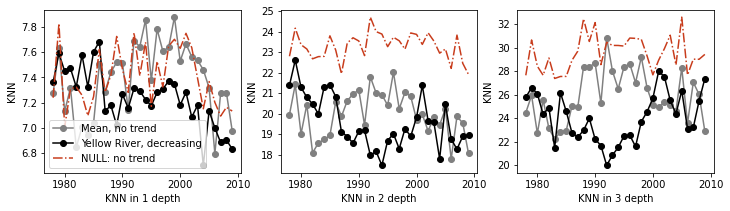

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for i, result in enumerate([result_depth1, result_depth2, result_depth3]):
    plot_mean_yr_china(result, axs[i])
    nulls = get_all_random_networks_simulation(total, depth=i+1)
    null = nulls.mean(axis=1).values
    axs[i].plot(nulls.index, null, "-.", color="#C83C1C", lw='1.5', label='NULL: {}'.format(mk_test(null)[0]))
    axs[i].set_xlabel("KNN in {} depth".format(i+1))

axs[0].legend()
plt.show();

**Stressful Yellow River undertook an increasingly larger role in virtual crop water trade complexity**

True

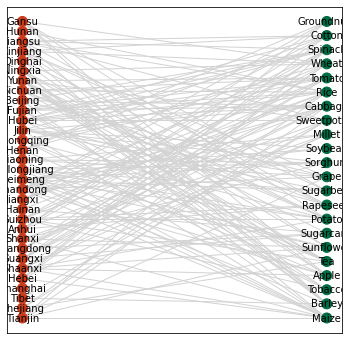

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_bipartite_graph(test.get_graph(), ax=ax)

In [12]:
# 计算所有度

def get_all_degrees(data):
    """
    获得所有的最近邻平均度 knn
    params: data, 一个可以转化成 TradeTable 的对象
    params: depth, 计算 KNN 的计算深度
    
    return: 各省份的计算结果
    """
    yrs = data.Year.sort_values().unique()
    result = pd.DataFrame(index=total['Province Name'].unique(), columns=total.Year.unique())
    for y in yrs:
        matrix = export_virtue_water_matrix(data, y)
        degrees = dict(TradeTable(matrix).get_graph().degree())
        for province in result.index:
            if province in degrees:
                degree = degrees[province]
            else:
                degree = np.nan
            result.loc[province, y] = degree
    return result


degrees = get_all_degrees(total)

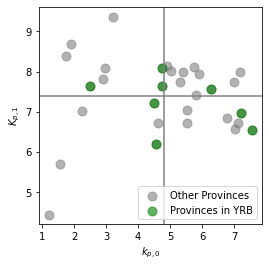

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

provinces = total['Province Name'].unique()
colors = ['red' if p in yellow_river_provinces else 'blue' for p in provinces]
k_1 = result_depth1.mean(axis=1)[provinces]
k_0 = degrees.mean(axis=1)[provinces]

size = 80
alpha = 0.6

ax.scatter(k_0, k_1, color='gray', s=size, alpha=alpha, label='Other Provinces')
ax.scatter(k_0[yellow_river_provinces], k_1[yellow_river_provinces], s=size, alpha=alpha, color='green', label='Provinces in YRB')
ax.set_xlabel("$k_{p,0}$")
ax.set_ylabel("$K_{p,1}$")

ax.axhline(k_1.mean(), color='gray')
ax.axvline(k_0.mean(), color='gray')
ax.legend(loc=4)

plt.savefig('../figs/quadrants.jpg')
plt.show();

## 最终做图

In [14]:
# 对散点获得最佳的线性拟合
def get_optmize_fit_linear(x_arr, y_arr):
    from scipy import optimize
    def linear(x, k, b):
        return k * x + b
    
    k, b = optimize.curve_fit(linear, x_arr, y_arr)[0]  # 最小二乘拟合直线
    y_simu = linear(x_arr, k, b)  # 拟合直线的预测Y
    return y_simu


def plot_depth_index_with_err_space(depth, repeats=10, start_yr=1979, end_yr=2008, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    # 数据
    yrs = np.arange(start_yr, end_yr + 1)

    # 修饰
    color_err = "#29303C"
    color_fill = 'lightgray'
    color_yr = '#0889A6'
    color_all = '#29303C'
    alpha=0.2
    ax.set_xlim(start_yr, end_yr)

    # 主要结果
    result_plot = get_all_index_results(total, depth=depth)
    y_yr = result_plot.loc[yellow_river_provinces, yrs].mean().values
    y_all = result_plot.mean().loc[yrs].values

#     ax.scatter(yrs, y_yr, color=color_yr)
#     ax.plot(yrs, get_optmize_fit_linear(yrs, y_yr), color=color_yr, label="YRB")
#     ax.scatter(yrs, y_all, color=color_all, alpha=alpha)
#     ax.plot(yrs, get_optmize_fit_linear(yrs, y_all), color=color_all, alpha=alpha, label="National Avg.")

    plot_gam_and_interval(yrs, y_yr, main_color=color_yr, y_label='YRB', ax=ax, err_space=False)
    plot_gam_and_interval(yrs, y_all, main_color=color_all, y_label='National Avg.', ax=ax, err_space=False)

    # 误差
    errs = {
        1: [],
        2: [],
        3: [],
    }

    err_min, err_max = [], []
    for y in yrs:
        tb = TradeTable(export_virtue_water_matrix(total, y))
        tmp_1, tmp_2, tmp_3 = [], [], []

        for i in range(repeats):
            tmp_1.append(get_mean_nearest_nbr_degree(tb.copy_absolute_random_graph(), depth=depth))
            tmp_2.append(get_mean_nearest_nbr_degree(tb.copy_one_side_random_graph(top='index'), depth=depth))
            tmp_3.append(get_mean_nearest_nbr_degree(tb.copy_one_side_random_graph(top='column'), depth=depth))

        errs[1].append(np.mean(tmp_1))
        errs[2].append(np.mean(tmp_2))
        errs[3].append(np.mean(tmp_3))

        err_max.append(np.max([tmp_1, tmp_2, tmp_3]))
        err_min.append(np.min([tmp_1, tmp_2, tmp_3]))

    err_max = np.array(err_max)
    err_min = np.array(err_min)
    ax.fill_between(yrs, err_min, err_max, color=color_fill, alpha=alpha, label='Err. space')

    lss = [':', '-.', '--']
    for k in errs:
        err = np.array(errs[k])
        errs[k] = err
        ax.plot(yrs, err, lw=1, color=color_err, ls=lss[k-1], label='NULL {}'.format(k))

    
# 修饰
# plot_depth_index_with_err_space(2)
plt.show();

In [15]:
# 使用图片的比例来定位
def get_position_by_ratio(ax, x_ratio, y_ratio):
    """
    使用图片的比例来返回定位，从而更好的控制说明文字的位置
    ax: 一个 matplotlib 的画图轴对象
    x_ratio: 横坐标的比例位置
    y_ratio: 纵坐标的比例位置
    """
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    x = (x_max-x_min) * x_ratio + x_min
    y = (y_max-y_min) * y_ratio + y_min
    return x, y

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


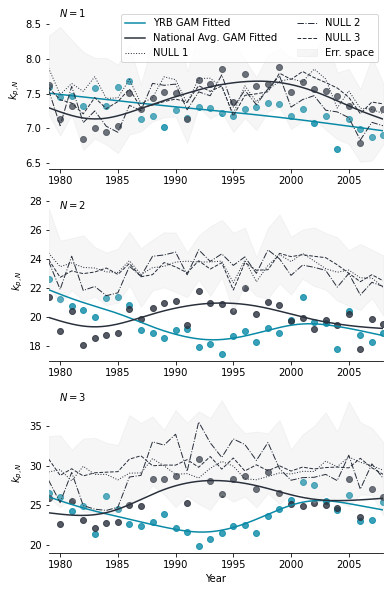

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))
for i, ax in enumerate(axs):
    depth = i+1
    plot_depth_index_with_err_space(depth, repeats=10, ax=ax)
    ax.text(*get_position_by_ratio(ax, 0.03, 0.95), "$N={}$".format(depth), weight='bold', )
    ax.set_ylabel("$k_{p, N}$")
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[0].legend(ncol=2)
axs[2].set_xlabel("Year")

plt.savefig("../figs/causes.jpg", dpi=300)
plt.show();